In [161]:
%matplotlib  inline
import pandas as pd
import iexfinance as iex
from datetime import datetime
import quandl
import plotly as py
import plotly.graph_objs as go
import multiprocessing
from functools import partial
import xgboost
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.cross_validation import *
import sklearn.preprocessing as prep
import time
import sklearn.feature_selection as fs
import sklearn.model_selection as ms
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from scipy import poly1d
from scipy.stats import pearsonr
import seaborn as sns
from math import sqrt
import datetime
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
from pykalman import KalmanFilter
pd.set_option('display.max_columns', 100)
pd.options.display.max_rows = 999

In [3]:
import scipy.ndimage as ndimage

def customLoss(actual,pred):
    alpha = 100
    t = 0
    if (actual * pred > 0):
        t = abs(actual-pred)
    else:
        t = alpha*pred**2 - np.sign(actual)*pred + abs(actual)
    return (t)

def macd(close, n_fast=12, n_slow=26,  n_sign=9, fillna=True):
    emafast = close.ewm(n_fast).mean()
    emaslow = close.ewm(n_slow).mean()
    macd = emafast - emaslow
    if fillna:
        macd = macd.fillna(0)
    macdsig = macd.ewm(n_sign).mean()
    if fillna:
        macd = macd.fillna(0)
        macdsig = macdsig.fillna(0)
    return macd, macdsig

def simple_returns(df):
    df = df.pct_change().fillna(0)
    return df

def rsi(close, period=14, fillna=True):
    diff = close.diff()
    which_dn = diff < 0

    up, dn = diff, diff*0
    up[which_dn], dn[which_dn] = 0, -up[which_dn]

    emaup = up.ewm(period).mean()
    emadn = dn.ewm(period).mean()

    rsi = 100 * emaup/(emaup + emadn)
    if fillna:
        rsi = rsi.fillna(50)
    return pd.Series(rsi, name='rsi')

def wavetrend(high,low,close,n1=10,n2=21):
    ap = (high+low+close)/3
    esa = close.ewm(n1).mean()
    d = abs(ap - esa).ewm(n1).mean()
    ci = (ap - esa) / (0.02 * d)
    tci = ci.ewm(n2).mean()
    
    wt1=tci
    wt2=wt1.rolling(n2).mean()
    wt2=wt2.fillna(method ='backfill')
    return wt1, wt2

def log_returns(df):
    """Calculate logReturns of price series"""
    log_ret = np.log(df) - np.log(df.shift(1))
    return log_ret

def tsi(close, r=25, s=13, fillna=True):
    """Calculate TSI Indicator of close price series"""
    m = close - close.shift(1)
    m1 = m.ewm(r).mean().ewm(s).mean()
    m2 = abs(m).ewm(r).mean().ewm(s).mean()
    tsi = m1/m2
    if fillna:
        tsi = tsi.fillna(0)
    return pd.Series(100*tsi, name='tsi')

def on_balance_volume(close, volume):
    """Calculate OBV Indicator of close price series and Volume"""
    df = pd.DataFrame([close, volume]).transpose()
    df['OBV'] = 0
    c1 = close < close.shift(1)
    c2 = close > close.shift(1)
    if c1.any():
        df.loc[c1, 'OBV'] = - volume
    if c2.any():
        df.loc[c2, 'OBV'] = volume
    return df['OBV']

def average_true_range(high, low, close, period=14, fillna=False):
    """Average True Range (ATR)
    The indicator provide an indication of the degree of price volatility.
    Strong moves, in either direction, are often accompanied by large ranges,
    or large True Ranges.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:average_true_range_atr
    Args:
        high(pandas.Series): dataset 'High' column.
        low(pandas.Series): dataset 'Low' column.
        close(pandas.Series): dataset 'Close' column.
        n(int): n period.
    Returns:
        pandas.Series: New feature generated.
    """
    cs = close.shift(1)
    tr = high.combine(cs, max) - low.combine(cs, min)
    tr = tr.ewm(period).mean()
    if fillna:
        tr = tr.fillna(0)
    return pd.Series(tr, name='atr')

def kst(close, r1=10, r2=15, r3=20, r4=30, n1=10, n2=10, n3=10, n4=15, nsig=9, fillna=True):
    """Calculate KST Indicator of close price series. See https://en.wikipedia.org/wiki/KST_oscillator"""
    rocma1 = (close / close.shift(r1) - 1).rolling(n1).mean()
    rocma2 = (close / close.shift(r2) - 1).rolling(n2).mean()
    rocma3 = (close / close.shift(r3) - 1).rolling(n3).mean()
    rocma4 = (close / close.shift(r4) - 1).rolling(n4).mean()
    kst = 100*(rocma1 + 2*rocma2 + 3*rocma3 + 4*rocma4)
    sig = kst.rolling(nsig).mean()
    if fillna:
        sig = sig.fillna(0)
    return pd.Series(sig, name='sig')

def find_nearest(array, value,findMax=True):
    """Find nearest value of extreme value"""
    array = np.sort(np.asarray(array))
    if findMax:
        array = array[array>=value]
    else:
        array = array[array<=value]
    if array.size > 0:
        idx = (np.abs(array - value)).argmin()
        return array[idx]
    else:
        return np.nan

def local_extreme(array, min_distance = 20, periodic=False, edges_allowed=True,find_max=True): 
    """Find all local maxima of the array, separated by at least min_distance."""
    array = np.asarray(array)
    cval = 0 
    if periodic: 
        mode = 'wrap' 
    elif edges_allowed: 
        mode = 'nearest' 
    else: 
        mode = 'constant' 
    cval = array.max()+1 
    if find_max:
        max_points = array == ndimage.maximum_filter(array, 1+2*min_distance, mode=mode, cval=cval) 
    else:
        max_points = array == ndimage.minimum_filter(array, 1+2*min_distance, mode=mode, cval=cval) 
        
    return [indices[max_points] for indices in np.indices(array.shape)]

def extreme_significance(exArray, tolerance=0.02,signi_level=2):
    """Find Significance of extreme values within tolerance bound."""
    array = np.asarray(exArray)
    array = np.ravel(array)
    signifArr = np.zeros(len(array))
    d = {'data': array, 'sign': signifArr}
    result = pd.DataFrame(data=d).values
    #print('len of x is: '+repr(len(result)))
    for i in range(len(result)):
        val = result[i,0]
        signif = 0
        for j in range(i+1,len(result)):
            if (result[j,0]>= val*(1-tolerance)) and  (array[j]<= val*(1+tolerance)):
                    signif = signif + 1
            result[i,1] = signif
            
    result = pd.DataFrame(data=result,columns=['ExtremeValue', 'Significance'])
    result = result[result.Significance>=signi_level]
    return result.sort_values(by=['Significance'],ascending=False)

def grouper(iterable, tolerance):
    """Group extremes by cluster based on relative price distance."""
    # if Dataframe take first column
    if isinstance(iterable,pd.core.frame.DataFrame):
        iterable = iterable.sort_values(by=iterable.columns[0]).iloc[:,0].values
    elif isinstance(iterable,np.ndarray):
        iterable =np.sort(iterable)
    prev = None
    group = []
    for item in iterable:
        if not prev or item - prev <= tolerance*item:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group
def group_extremes(inp,max_distance):
    """Calculate centroid for each cluster of prices"""
    inp = dict(enumerate(grouper(inp,max_distance), 1))
    avgDict = {}
    for k,v in inp.items():
        # v is the list of items for dict row k
        avgDict[k] = sum(v)/ float(len(v))
    return list(avgDict.values())

def highest_high(df,period=21):
    df = df.rolling(window=period,center=False,min_periods=1).max()
    return df

def momentum(df,period=10):
    df = df - df.shift(period)
    df[0:period] = 0
    return df

def trading_range(df_high,df_low):
    df = df_high-df_low
    return df

def lowest_low(df,period=21):
    df = df.rolling(window=period,center=False,min_periods=1).min()
    return df

def calc_extreme_distance(series,sup_array,res_array):
    import math
    if isinstance(series,pd.core.frame.DataFrame):
        series = np.ravel(series.values())
    elif isinstance(series,np.ndarray):
        series =np.ravel(series)
    sup_array = np.ravel(np.array(sup_array))
    res_array = np.ravel(np.array(res_array))
    dist_s = []
    dist_r = []
    #if not sup_array:
    #    print("test")
    #else:
    for i in range(len(series)):
        curr_value = series[i]
        nearest_sup = find_nearest(sup_array, curr_value,findMax=False)
        nearest_res = find_nearest(res_array, curr_value)
        if curr_value*1.1 < nearest_sup:
            dist_s.append(curr_value/2)
        elif curr_value > nearest_res*1.1:
            dist_r.append(curr_value/2)
        else:
            sup_val = curr_value-nearest_sup
            res_val = nearest_res-curr_value
            if np.isnan(sup_val):
                sup_val = (curr_value/2)
            if np.isnan(res_val):
                res_val = (curr_value/2)
            dist_s.append(sup_val)
            dist_r.append(res_val)
    if dist_s and dist_r:
        return dist_s,dist_r
    
def r_score(y_true, y_pred, sample_weight=None, multioutput=None):
    r2 = r2_score(y_true, y_pred, sample_weight=sample_weight, multioutput=multioutput)
    r = (np.sign(r2)*np.sqrt(np.abs(r2)))
    if r <= -1:
        return -1
    else:
        return r
    
def calc_r_score (actual_and_test):
    r = []
    r.append(0)
    for i in range(1,len(actual_and_test)):
        ri = r_score(actual_and_test[0:i,0],actual_and_test[0:i,1])
        if ri <= -1:
            ri = 0
        r.append(ri)
    return r

def calc_kalman(dataframe):
    if isinstance(dataframe,pd.core.frame.DataFrame) or isinstance(dataframe,pd.core.series.Series):
        array = dataframe.values
    else:
        array = dataframe
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)
    state_means, _ = kf.filter(array)
    state_means = state_means.flatten()
    state_means = pd.DataFrame(data=state_means,index=dataframe.index)
    state_means.columns = ['KF']
    state_means["KF"][0:9]  = float(np.mean(state_means[9:15]).values)
    return state_means

def calc_extreme_groups (dataframe,find_max=True,mDistance = 100,tolerance=0.0009,signi_level=1):
    """Group extremes by cluster based on absolute price distance.
       Input: series or dataframe
       find_max: maximum (resistance) or minimum (suppport) search
       mDistance: minimumdistance in an array to find local extremes
       tolerance: tolerance level in percent to group other extremes
       signi_level: leave 1 """
    if isinstance(dataframe,pd.core.frame.DataFrame) or isinstance(dataframe,pd.core.series.Series):
        array = np.ravel(dataframe.values)     
    array = np.ravel(array[local_extreme(array,min_distance= mDistance,find_max=find_max)])
    signify =extreme_significance(array, tolerance=tolerance,signi_level=signi_level)
    extreme = group_extremes(signify,tolerance)
    return array,signify,extreme

def calc_next_extreme_distance (dataframe,extremes_sup=None,extremes_res=None):
    """Given a series and their supports and resistances
    calculate the distances to the next supports or resistances."""
    if isinstance(dataframe,pd.core.frame.DataFrame) or isinstance(dataframe,pd.core.series.Series):
        array = np.ravel(dataframe.values) 
    [sup,res] = calc_extreme_distance(array,extremes_sup,extremes_res) 
    sr = pd.DataFrame(data=np.transpose([sup,res]),index=dataframe.index )
    sr.columns = ['support_distance', 'resistance_distance']
    return sr

In [4]:
EURUSD = pd.read_csv('EURUSD.txt',delimiter=',',dtype={'<TIME>': str})
EURUSD.columns = EURUSD.columns.str.replace("<", "")
EURUSD.columns = EURUSD.columns.str.replace(">", "")
EURUSD = EURUSD.drop(['VOL'], axis=1)
EURUSD['DATETIME'] = EURUSD['DTYYYYMMDD'].astype(str) + ":" + EURUSD['TIME'].astype(str)
EURUSD = EURUSD.drop(['DTYYYYMMDD','TIME'], axis=1)
EURUSD['DATETIME']  = pd.to_datetime(EURUSD['DATETIME'],format='%Y%m%d:%H%M%S',  infer_datetime_format=False)
EURUSD.index = pd.to_datetime(EURUSD['DATETIME'],format='%Y%m%d:%H%M%S',  infer_datetime_format=False, unit="m")

In [85]:
EURUSD_1H = EURUSD.resample('1H').agg({'OPEN': 'first', 
                                 'HIGH': 'max', 
                                 'LOW': 'min', 
                                 'CLOSE': 'last'})

EURUSD_4H = EURUSD.resample('4H').agg({'OPEN': 'first', 
                                 'HIGH': 'max', 
                                 'LOW': 'min', 
                                 'CLOSE': 'last'})

EURUSD_1H = EURUSD_1H.dropna()
EURUSD_4H = EURUSD_4H.dropna()

Text(0.5,1,'Local extremes')

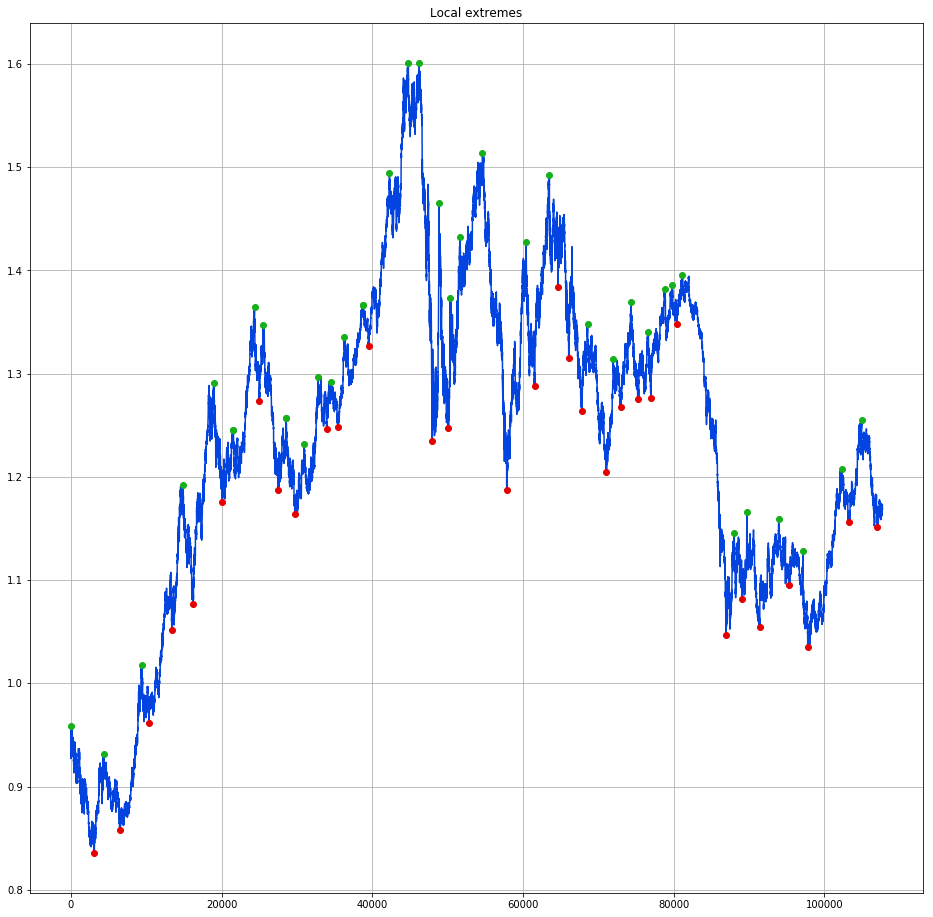

In [86]:
cl=np.ravel(EURUSD_1H[['CLOSE']].values)
plt.rc("figure",figsize=(16,16))
plt.plot(cl,color='xkcd:blue',linestyle ='-')
mDistance = 1000
plt.plot(np.ravel(local_extreme(cl,min_distance= mDistance,find_max=True)),
         np.ravel(cl[local_extreme(cl,min_distance= mDistance,find_max=True)]) ,color='xkcd:green',marker='o',linestyle ='')
plt.plot(np.ravel(local_extreme(cl,min_distance= mDistance,find_max=False)),
         np.ravel(cl[local_extreme(cl,min_distance= mDistance,find_max=False)]) ,color='xkcd:red',marker='o',linestyle ='')
plt.grid(True)
plt.title("Local extremes")

localextremes:192
signify:9  signimax:4.0
extremes:5


Text(0.5,1,'resistances')

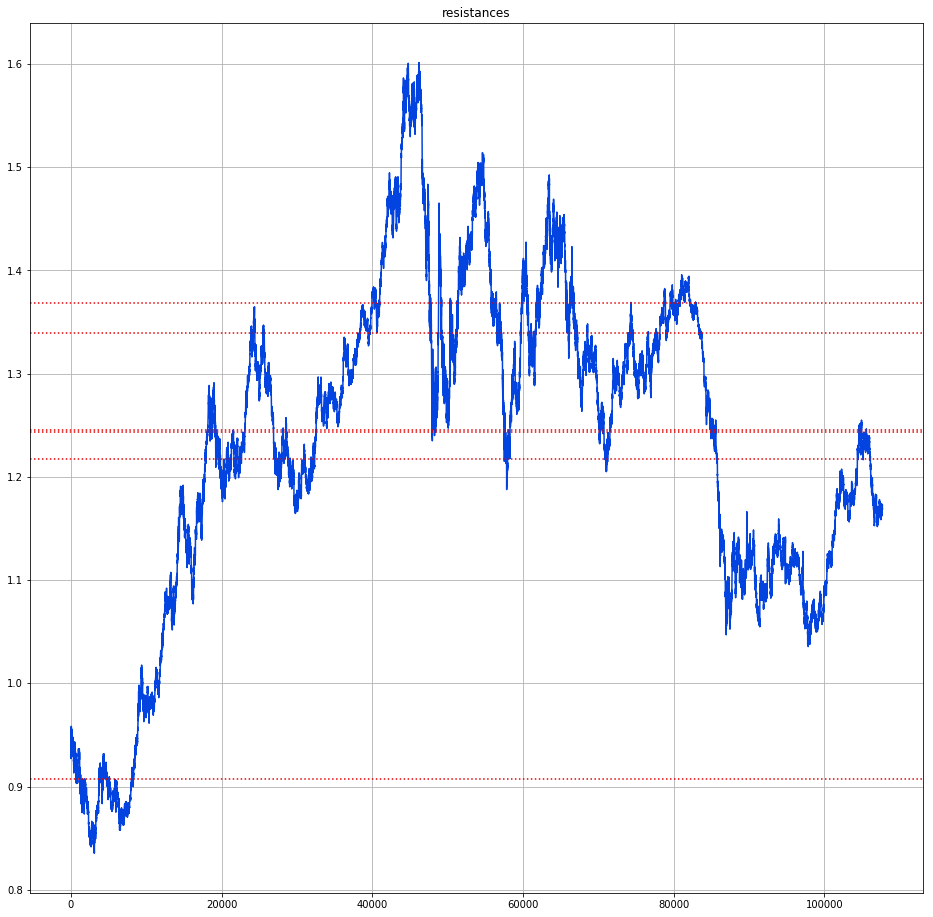

In [87]:
tolerance= 0.001
signi_level=3
min_distance= 180
array = np.ravel(cl[local_extreme(cl,min_distance= min_distance,find_max=False)])
#signify =extreme_significance(array, tolerance=tolerance,signi_level=signi_level)
signify =extreme_significance(array, tolerance=tolerance,signi_level=signi_level)
extreme = group_extremes(signify,tolerance)
print('localextremes:' + repr(len(array)))
print('signify:' + repr(len(signify)), ' signimax:' +repr(np.max(signify['Significance'])))
print('extremes:' + repr(len(extreme)))
      
_,_,extremes_res = calc_extreme_groups(EURUSD_1H[['CLOSE']],signi_level=signi_level,
                                   tolerance=tolerance,mDistance = min_distance,find_max=True)
plt.rc("figure",figsize=(16,16))
plt.plot(cl,color='xkcd:blue',linestyle ='-')
yval = np.ravel(extremes_res)
for x in yval:
    plt.axhline(y=x,color='xkcd:red',linestyle =':')
plt.grid(True)
plt.title("resistances")

localextremes:192
signify:9  signimax:4.0
extremes:5


Text(0.5,1,'Supports')

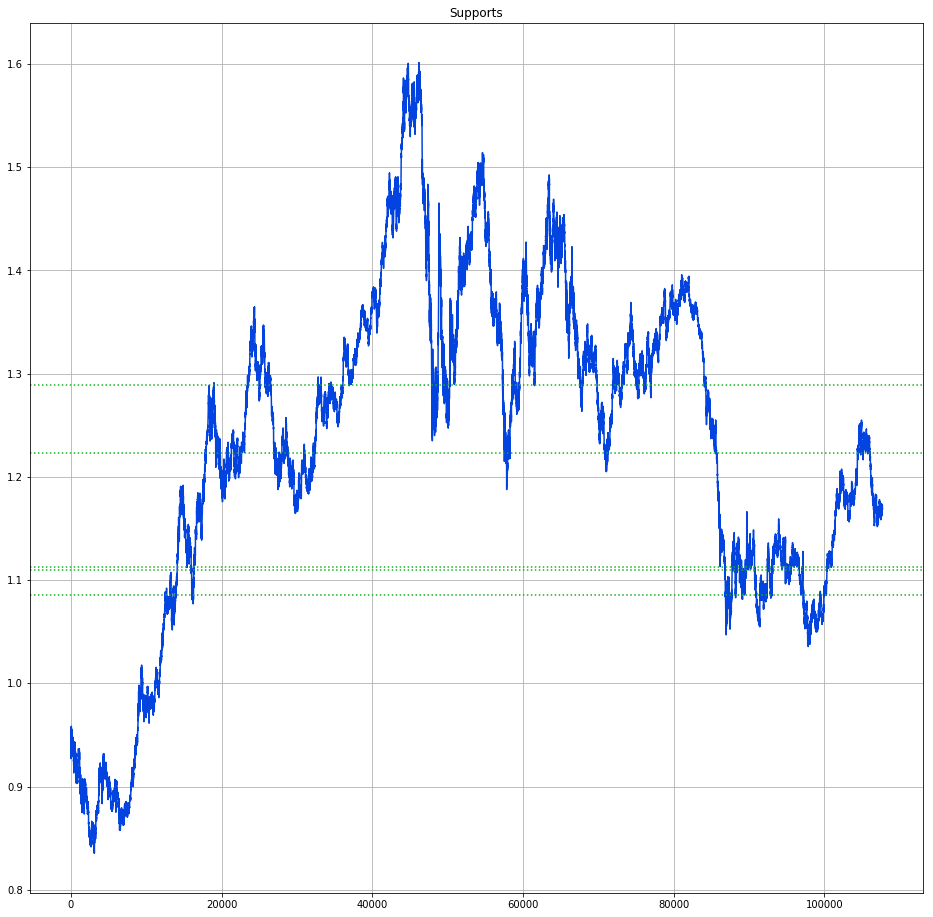

In [88]:
# Show horizontal resistance levels based on extreme points and significance
__,__,extremes_sup = calc_extreme_groups(EURUSD_1H[['CLOSE']],signi_level=signi_level,
                                   tolerance=tolerance,mDistance = min_distance,find_max=False)
plt.rc("figure",figsize=(16,16))
plt.plot(cl,color='xkcd:blue',linestyle ='-')
yval = np.ravel(extremes_sup)
print('localextremes:' + repr(len(array)))
print('signify:' + repr(len(signify)), ' signimax:' +repr(np.max(signify['Significance'])))
print('extremes:' + repr(len(extreme)))
for x in yval:
    plt.axhline(y=x,color='xkcd:green',linestyle =':')
plt.grid(True)
plt.title("Supports")

In [89]:
from pyti.stochrsi import stochrsi as stochrsi
from pyti.commodity_channel_index import commodity_channel_index as cci

def feature_engineering_dates(df):
    import pandas as pd
    from datetime import timedelta
    #df['Date'] = pd.to_datetime("'2015-10-01'") # I guess this date is right :P
    #df['Date'] = df['DATETIME'] + df['Day'].map(timedelta) - timedelta(days=1)
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['Week'] = df.index.weekofyear
    df['Weekday'] = df.index.weekday
    df['DayMonth'] = df.index.day
    return df

def feature_engineering_ta(df):
        # bollinger bands
    df['TSI'] = tsi(df['CLOSE'])
    df['ATR'] = average_true_range(df['HIGH'],df['LOW'],df['CLOSE'],period=14)
    df['WT1'],df['WT2'] = wavetrend(df['HIGH'],df['LOW'],df['CLOSE'],n1=10,n2=21)
    df['KF'] = calc_kalman(df['CLOSE'])
    df['KST'] = kst(df['CLOSE'])
    df['HIGHESTHIGH'] = highest_high(df['HIGH'],period=21)
    df['LOWESTLOW'] = lowest_low(df['LOW'],period=21)
    df['TRADINGRANGE'] = trading_range(df['HIGH'],df['LOW'])
    df['MOMENTUM'] = momentum(df['CLOSE'],period=10)
    df['RSI'] = rsi(df['CLOSE'],period=14)
    df['MACD'],df['MACDSIGNAL'] = macd(df['CLOSE'])
    df['STOCHRSI'] = stochrsi(df['CLOSE'], 14)
    df['CCI'] = cci(df['CLOSE'],df['HIGH'],df['LOW'], 20)
    return df

def feature_engineering_statistics(df_grouped,cols):
    for c in cols:
        # rolling
        for h in [11, 21]:
            df_grouped[c+'_rolling_mean_'+str(h)] = df_grouped[c].rolling(h, min_periods=0).mean()
        # diffs
        df_grouped[c+'_diff_1'] = df_grouped[c].diff().fillna(method="backfill")
        df_grouped[c+'_diff_2'] = df_grouped[c].diff(2).fillna(method="backfill")
        df_grouped[c+'_diff_3'] = df_grouped[c].diff(3).fillna(method="backfill")
        # cumsum
        df_grouped[c+'_cumsum'] = df_grouped[c].cumsum()
        # shift columns
        df_grouped[c+'_shift1'] = df_grouped[c].shift(1).fillna(0)
        df_grouped[c+'_shift2'] = df_grouped[c].shift(2).fillna(0)
        df_grouped[c+'_shift3'] = df_grouped[c].shift(3).fillna(0)
    return df_grouped


In [101]:
EURUSD_1H = feature_engineering_dates(EURUSD_1H)
EURUSD_1H = feature_engineering_ta(EURUSD_1H)
EURUSD_1H = EURUSD_1H.fillna(method='bfill')

cols = ['TSI','ATR','KF','KST','HIGHESTHIGH','LOWESTLOW','TRADINGRANGE','MOMENTUM','RSI','MACD','MACDSIGNAL','WT1','WT2','STOCHRSI','CCI']
#EURUSD_1H = feature_engineering_statistics(EURUSD_1H,cols)

# plot example for wave trend

In [116]:
start = EURUSD_1H.index.searchsorted(datetime.datetime(2001, 1, 22))
end = EURUSD_1H.index.searchsorted(datetime.datetime(2001, 2, 25))
EURUSD_temp =EURUSD_1H.iloc[start:end]

# start plotting
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools
py.tools.set_credentials_file(username='profiler84', api_key='Jt8y8BVFAZRt6jSX6ehC')
py.tools.set_config_file(world_readable=True, sharing='public')
init_notebook_mode(connected=True)
data = go.Candlestick(x=EURUSD_temp.index, open=EURUSD_temp['OPEN'],high=EURUSD_temp['HIGH'],low=EURUSD_temp['LOW'],
                      close=EURUSD_temp['CLOSE'])

wt1 = go.Scatter(
    x=EURUSD_temp.index,
    y=EURUSD_temp['WT1'],
    name = 'WT1'
)

wt2 = go.Scatter(
    x=EURUSD_temp.index,
    y=EURUSD_temp['WT2'],
    name = 'WT2'
)
wt3 = go.Scatter(
    x=EURUSD_temp.index,
    y=EURUSD_temp['STOCHRSI'],
    name = 'STOCHRSI'
)
#py.plotly.iplot(wt,filename='basic_candle', auto_open=True)
fig = tools.make_subplots(rows=2, cols=1)
fig.append_trace(data, 1, 1)
fig.append_trace(wt1, 2, 1)
fig.append_trace(wt2, 2, 1)
#fig.append_trace(wt3, 2, 1)
py.plotly.iplot(fig,filename='basic_candle', auto_open=True)

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~profiler84/0 or inside your plot.ly account where it is named 'basic_candle'


# Create target

In [91]:
def calc_profit_loss(i=None,data=None,profit=0.01):
    start = data['CLOSE'][i]
    starttime = data.index[i]
    if (i+1)>len(data):
        return
    search = data[i+1:]
    longvalue = float('NaN')
    shortvalue = float('NaN')
    try:
        longtime = search[search['HIGH']>=start*(1+profit)].index[0]
        longvalue = search[search['HIGH']>=start*(1+profit)]
        longvalue = longvalue['HIGH'][0]
    except Exception as e:
        ts = time.time()
        longtime = datetime.datetime.fromtimestamp(ts)
    try:
        shorttime = search[search['LOW']<= start*(1-profit)].index[0]
        shortvalue = search[search['LOW']<= start*(1-profit)]
        shortvalue = shortvalue['LOW'][0]
    except Exception as e:
        ts = time.time()
        shorttime = datetime.datetime.fromtimestamp(ts)
    #print( "longtime=" + str(longtime) + ",shorttime=" + str(shorttime))
    
    if longtime<shorttime:
        return starttime,1,(longtime-starttime).seconds/3600,start,longvalue
    elif longtime>shorttime:
        return starttime,-1,(shorttime-starttime).seconds/3600,start,shortvalue
    elif longtime.date()==shorttime.date() and longtime.minute == shorttime.minute:
        return float('NaN'),float('NaN'),float('NaN'),float('NaN'),float('NaN')

In [92]:
profit = 0.01 # in EURUSD Notation
data = EURUSD_1H[['HIGH','LOW','CLOSE']]
start = data['CLOSE'][1]
starttime = data.index[1]
search = data[2:]
longvalue = search[search['HIGH']>=start*(1+profit)]
longvalue = longvalue['HIGH'][0]
search[search['HIGH']>=start*(1+profit)].index[0]

Timestamp('2001-01-05 07:00:00')

In [15]:
profit = 0.01 # in EURUSD Notation
data = EURUSD_1H[['HIGH','LOW','CLOSE']]
start = time.time()
inputs = range(len(data))
#pool = multiprocessing.Pool(processes=8)
#processes  = [multiprocessing.Process(target=calc_profit_loss, args=(x,data, profit)) for x in inputs]
results = Parallel(n_jobs=4,verbose=1)(delayed(calc_profit_loss)(x, data, profit) for x in inputs)
#results = [pool.apply_async(calc_profit_loss, args=(x,data, profit)) for x in inputs]

#import sys
#for i, _ in enumerate(results, 1):
#    print('at: ' + str(i))
#pool.close()
#pool.terminate()
#pool.join()

# Get process results from the output queue
#output = [p.get() for p in results]
#output.to_csv('EUR_USD_1H_with_Target.csv')
end = time.time()
print('time elapsed: ' + str(end - start))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  48 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 644 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 1644 tasks      | elapsed:   25.6s
[Parallel(n_jobs=4)]: Done 3044 tasks      | elapsed:   48.0s
[Parallel(n_jobs=4)]: Done 4844 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 7044 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 9644 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 12644 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 16044 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 19844 tasks      | elapsed:  4.5min
[Parallel(n_jobs=4)]: Done 24044 tasks      | elapsed:  5.2min
[Parallel(n_jobs=4)]: Done 28644 tasks      | elapsed:  6.0min
[Parallel(n_jobs=4)]: Done 33644 tasks      | elapsed:  6.8min
[Parallel(n_jobs=4)]: Done 39044 tasks      | elapsed:  7.5min
[Parallel(n_jobs=4)]: Done 44844 tasks      | elapse

time elapsed: 815.5222389698029


[Parallel(n_jobs=4)]: Done 107698 out of 107698 | elapsed: 13.6min finished


In [93]:
results = [x for x in results if x is not None]
results = [x for x in results if str(x) != 'nan']
results[2]

(Timestamp('2001-01-03 01:00:00'), -1, 17.0, 0.9505, 0.9337)

In [103]:
results = [x for x in results if x is not None]
df = pd.DataFrame(results, columns=['pos','signal', 'time_diff_hours','start_price','end_price'])
df.index = df['pos']
df = df.drop(['pos'], axis=1)

data_merged = EURUSD_1H.merge(df, left_index=True,right_index =True, how='left', indicator=True)
data_merged = data_merged.dropna()
data_merged = data_merged.drop(['_merge'], axis=1)
data_merged = data_merged[data_merged['time_diff_hours'] !=0]
data_merged['pct_change'] = (data_merged['end_price']/data_merged['start_price'])-1
data_merged['weight'] = 1/data_merged['time_diff_hours']
data_merged['weighted_target'] = data_merged['weight']*data_merged['pct_change']
data_merged.to_csv('EURUSD_1H_signal_data.csv')

# mean weekday performance

Text(0.5,1,'Bar 6 = Sunday 23:00')

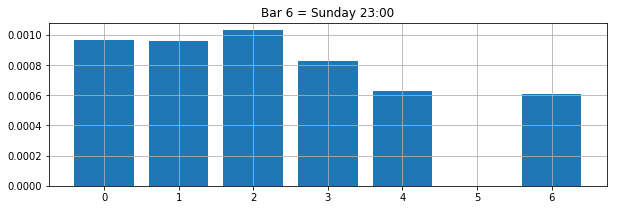

In [166]:
bars = data_merged.groupby(['Weekday'])['pct_change'].mean()
plt.rc("figure",figsize=(10,3))
plt.bar(bars.index,bars)
plt.grid()
plt.title('Bar 6 = Sunday 23:00')

# sum weekday performance

Text(0.5,1,'Bar 6 = Sunday 23:00')

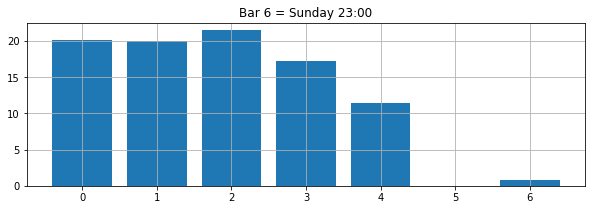

In [167]:
bars = data_merged.groupby(['Weekday'])['pct_change'].sum()
plt.rc("figure",figsize=(10,3))
plt.bar(bars.index,bars)
plt.grid()
plt.title('Bar 6 = Sunday 23:00')

# sum weekday signal

Text(0.5,1,'Bar 6 = Sunday 23:00')

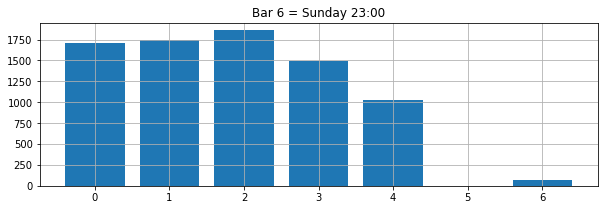

In [168]:
bars = data_merged.groupby(['Weekday'])['signal'].sum()
plt.rc("figure",figsize=(10,3))
plt.bar(bars.index,bars)
plt.grid()
plt.title('Bar 6 = Sunday 23:00')

# mean daymonth performance

Text(0.5,1,'Bar 6 = Sunday 23:00')

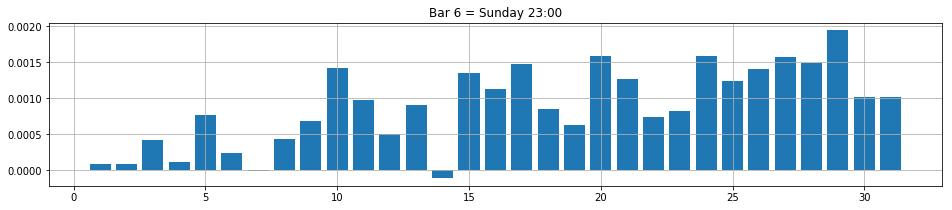

In [171]:
bars = data_merged.groupby(['DayMonth'])['pct_change'].mean()
plt.rc("figure",figsize=(16,3))
plt.bar(bars.index,bars)
plt.grid()

# sum day month signal 

Text(0.5,1,'Bar 6 = Sunday 23:00')

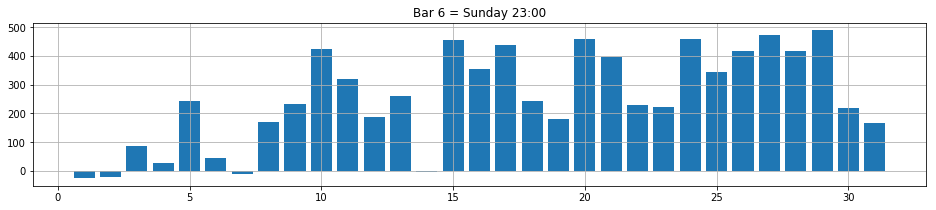

In [172]:
bars = data_merged.groupby(['DayMonth'])['signal'].sum()
plt.rc("figure",figsize=(16,3))
plt.bar(bars.index,bars)
plt.grid()

# sum month signal

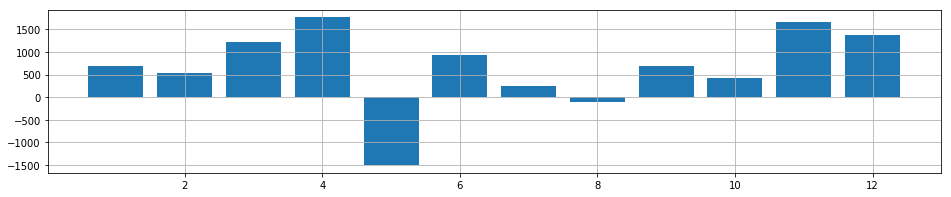

In [176]:
bars = data_merged.groupby(['Month'])['signal'].sum()
plt.rc("figure",figsize=(16,3))
plt.bar(bars.index,bars)
plt.grid()

# sum month performance

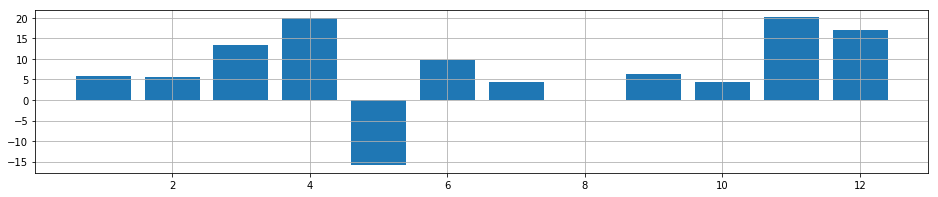

In [174]:
bars = data_merged.groupby(['Month'])['pct_change'].sum()
plt.rc("figure",figsize=(16,3))
plt.bar(bars.index,bars)
plt.grid()

# mean month performance

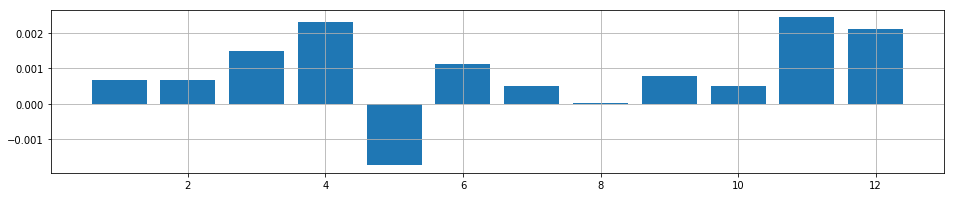

In [175]:
bars = data_merged.groupby(['Month'])['pct_change'].mean()
plt.rc("figure",figsize=(16,3))
plt.bar(bars.index,bars)
plt.grid()

# summary

In [108]:
data_merged.head(32)

,OPEN,HIGH,LOW,CLOSE,Year,Month,Week,Weekday,DayMonth,TSI,ATR,WT1,WT2,KF,KST,HIGHESTHIGH,LOWESTLOW,TRADINGRANGE,MOMENTUM,RSI,MACD,MACDSIGNAL,STOCHRSI,CCI,signal,time_diff_hours,start_price,end_price,pct_change,weight,weighted_target
2001-01-02 23:00:00,0.9507,0.9509,0.9505,0.9506,2001,1,1,1,2,0.000000,0.000400,50.000000,32.504318,0.896865,0.0,0.9509,0.9505,0.0004,0.0000,50.000000,0.000000e+00,0.000000e+00,26.744514,-6.271984,-1.0,19.0,0.9506,0.9337,-0.017778,0.052632,-0.000936
2001-01-03 00:00:00,0.9506,0.9510,0.9492,0.9496,2001,1,1,2,3,-100.000000,0.001124,-9.871351,32.504318,0.896865,0.0,0.9510,0.9492,0.0018,0.0000,0.000000,-1.056604e-05,-5.561072e-06,26.744514,-6.271984,-1.0,18.0,0.9496,0.9337,-0.016744,0.055556,-0.000930
2001-01-03 01:00:00,0.9496,0.9509,0.9495,0.9505,2001,1,1,2,3,-51.126361,0.001223,6.524603,32.504318,0.896865,0.0,0.9510,0.9492,0.0014,0.0000,49.090909,-8.826300e-07,-3.834710e-06,26.744514,-6.271984,-1.0,17.0,0.9505,0.9337,-0.017675,0.058824,-0.001040
2001-01-03 02:00:00,0.9504,0.9508,0.9498,0.9499,2001,1,1,2,3,-43.544379,0.001161,10.228013,32.504318,0.896865,0.0,0.9510,0.9492,0.0010,0.0000,36.346154,-6.097027e-06,-4.492551e-06,26.744514,-6.271984,-1.0,16.0,0.9499,0.9337,-0.017054,0.062500,-0.001066
2001-01-03 03:00:00,0.9499,0.9507,0.9499,0.9503,2001,1,1,2,3,-35.510076,0.001079,23.696245,32.504318,0.896865,0.0,0.9510,0.9492,0.0008,0.0000,46.303592,-1.897504e-06,-3.858856e-06,26.744514,-6.271984,-1.0,15.0,0.9503,0.9337,-0.017468,0.066667,-0.001165
2001-01-03 04:00:00,0.9503,0.9506,0.9503,0.9506,2001,1,1,2,3,-28.715653,0.000925,37.938837,32.504318,0.896865,0.0,0.9510,0.9492,0.0003,0.0000,52.299689,6.471643e-06,-1.654118e-06,26.744514,-6.271984,-1.0,14.0,0.9506,0.9337,-0.017778,0.071429,-0.001270
2001-01-03 05:00:00,0.9506,0.9507,0.9505,0.9505,2001,1,1,2,3,-24.837550,0.000799,46.394716,32.504318,0.896865,0.0,0.9510,0.9492,0.0002,0.0000,50.293920,1.015981e-05,6.103740e-07,26.744514,-6.271984,-1.0,13.0,0.9505,0.9337,-0.017675,0.076923,-0.001360
2001-01-03 06:00:00,0.9505,0.9513,0.9503,0.9509,2001,1,1,2,3,-20.212647,0.000831,55.777291,32.504318,0.896865,0.0,0.9513,0.9492,0.0010,0.0000,57.310509,2.095580e-05,4.182675e-06,26.744514,-6.271984,-1.0,12.0,0.9509,0.9337,-0.018088,0.083333,-0.001507
2001-01-03 07:00:00,0.9510,0.9510,0.9468,0.9489,2001,1,1,2,3,-22.200497,0.001316,25.059167,32.504318,0.896865,0.0,0.9513,0.9468,0.0042,0.0000,32.632826,-1.358740e-05,1.281814e-06,26.744514,-6.271984,-1.0,11.0,0.9489,0.9337,-0.016019,0.090909,-0.001456
2001-01-03 08:00:00,0.9490,0.9543,0.9489,0.9539,2001,1,1,2,3,-8.796174,0.001863,40.198041,32.504318,0.878725,0.0,0.9543,0.9468,0.0054,0.0000,68.715648,6.927956e-05,1.172178e-05,26.744514,-6.271984,-1.0,10.0,0.9539,0.9337,-0.021176,0.100000,-0.002118


In [109]:
data_merged.describe()

,OPEN,HIGH,LOW,CLOSE,Year,Month,Week,Weekday,DayMonth,TSI,ATR,WT1,WT2,KF,KST,HIGHESTHIGH,LOWESTLOW,TRADINGRANGE,MOMENTUM,RSI,MACD,MACDSIGNAL,STOCHRSI,CCI,signal,time_diff_hours,start_price,end_price,pct_change,weight,weighted_target
count,103040.000000,103040.000000,103040.000000,103040.000000,103040.000000,103040.000000,103040.000000,103040.000000,103040.000000,103040.000000,103040.000000,103040.000000,103040.000000,103040.000000,103040.000000,103040.000000,103040.000000,103040.000000,103040.000000,103040.000000,103040.000000,103040.000000,103040.000000,103040.000000,103040.000000,103040.000000,103040.000000,103040.000000,103040.000000,103040.000000,103040.000000
mean,1.232748,1.233727,1.231780,1.232751,2009.264567,6.425175,26.196526,2.006609,15.684103,0.521984,0.001980,1.351465,1.353138,1.232721,0.060247,1.237983,1.227477,0.001947,0.000021,50.260520,0.000028,0.000028,50.200886,0.009079,0.076650,11.947147,1.232751,1.233732,0.000884,0.161546,0.000163
std,0.160428,0.160560,0.160287,0.160424,5.049555,3.424716,14.930276,1.463720,8.753397,16.430016,0.000884,29.946036,28.114685,0.160428,4.773829,0.161080,0.159748,0.001577,0.005002,12.654198,0.002496,0.002345,35.981618,2.023078,0.997063,6.595367,0.160424,0.160338,0.011322,0.205839,0.002963
min,0.835500,0.836200,0.835000,0.835400,2001.000000,1.000000,1.000000,0.000000,1.000000,-100.000000,0.000400,-71.715085,-65.806085,0.837519,-27.782880,0.840400,0.835000,0.000000,-0.041700,0.000000,-0.013403,-0.012318,0.000000,-17.757170,-1.000000,1.000000,0.835400,0.835200,-0.026239,0.043478,-0.026239
25%,1.125900,1.126800,1.125000,1.126000,2005.000000,3.000000,13.000000,1.000000,8.000000,-11.018251,0.001393,-23.933775,-22.143489,1.125612,-2.602935,1.130800,1.120800,0.000900,-0.002300,41.373545,-0.001374,-0.001300,15.803100,-1.002372,-1.000000,6.000000,1.126000,1.127500,-0.010636,0.055556,-0.000865
50%,1.256500,1.257600,1.255500,1.256500,2009.000000,6.000000,26.000000,2.000000,16.000000,0.826543,0.001788,1.946130,2.213159,1.256555,0.125659,1.262300,1.251300,0.001500,0.000000,50.347282,0.000098,0.000108,50.378851,0.032111,1.000000,12.000000,1.256500,1.257100,0.010077,0.083333,0.000497
75%,1.344300,1.345200,1.343300,1.344300,2014.000000,9.000000,39.000000,3.000000,23.000000,12.121650,0.002331,26.632566,24.474195,1.344394,2.787508,1.349200,1.338800,0.002400,0.002400,59.177030,0.001538,0.001444,84.721310,1.046632,1.000000,18.000000,1.344300,1.343900,0.010828,0.166667,0.001021
max,1.601400,1.603600,1.599000,1.601300,2018.000000,12.000000,53.000000,6.000000,31.000000,53.514986,0.009999,74.035459,67.491931,1.596783,30.007173,1.603600,1.593500,0.033100,0.049300,92.171446,0.020723,0.019505,100.000000,19.452957,1.000000,23.000000,1.601300,1.603600,0.031480,1.000000,0.029123


In [110]:
data_merged[data_merged['time_diff_hours'] ==0]

,OPEN,HIGH,LOW,CLOSE,Year,Month,Week,Weekday,DayMonth,TSI,ATR,WT1,WT2,KF,KST,HIGHESTHIGH,LOWESTLOW,TRADINGRANGE,MOMENTUM,RSI,MACD,MACDSIGNAL,STOCHRSI,CCI,signal,time_diff_hours,start_price,end_price,pct_change,weight,weighted_target


# correlations?

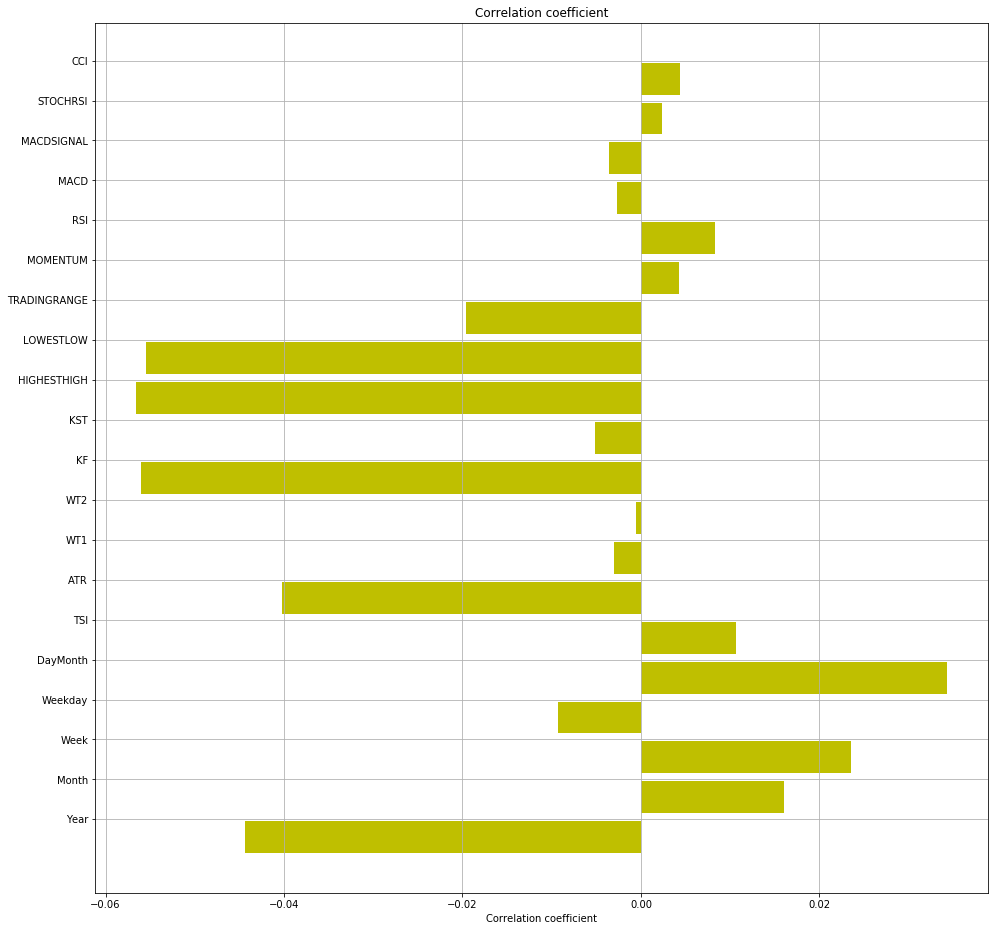

In [147]:
df = data_merged
# Now let us look at the correlation coefficient of each of these variables
x_cols = [col for col in df.columns if col not in ['OPEN','HIGH','LOW','CLOSE','start_price','end_price',
                                                   'time_diff_hours','pct_change','weighted_target','signal','weight']]

target_col = 'signal'
labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(df[col].values, df[target_col].values)[0,1])
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(16,16))
plt.grid(True)
rects = ax.barh(ind, np.array(values), color='y')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient")
#autolabel(rects)
plt.show()


# trading rules 

In [115]:
data_merged

,OPEN,HIGH,LOW,CLOSE,Year,Month,Week,Weekday,DayMonth,TSI,ATR,WT1,WT2,KF,KST,HIGHESTHIGH,LOWESTLOW,TRADINGRANGE,MOMENTUM,RSI,MACD,MACDSIGNAL,STOCHRSI,CCI,signal,time_diff_hours,start_price,end_price,pct_change,weight,weighted_target
2001-01-02 23:00:00,0.9507,0.9509,0.9505,0.9506,2001,1,1,1,2,0.000000,0.000400,50.000000,32.504318,0.896865,0.000000,0.9509,0.9505,0.0004,0.0000,50.000000,0.000000e+00,0.000000e+00,26.744514,-6.271984,-1.0,19.0,0.9506,0.9337,-0.017778,0.052632,-0.000936
2001-01-03 00:00:00,0.9506,0.9510,0.9492,0.9496,2001,1,1,2,3,-100.000000,0.001124,-9.871351,32.504318,0.896865,0.000000,0.9510,0.9492,0.0018,0.0000,0.000000,-1.056604e-05,-5.561072e-06,26.744514,-6.271984,-1.0,18.0,0.9496,0.9337,-0.016744,0.055556,-0.000930
2001-01-03 01:00:00,0.9496,0.9509,0.9495,0.9505,2001,1,1,2,3,-51.126361,0.001223,6.524603,32.504318,0.896865,0.000000,0.9510,0.9492,0.0014,0.0000,49.090909,-8.826300e-07,-3.834710e-06,26.744514,-6.271984,-1.0,17.0,0.9505,0.9337,-0.017675,0.058824,-0.001040
2001-01-03 02:00:00,0.9504,0.9508,0.9498,0.9499,2001,1,1,2,3,-43.544379,0.001161,10.228013,32.504318,0.896865,0.000000,0.9510,0.9492,0.0010,0.0000,36.346154,-6.097027e-06,-4.492551e-06,26.744514,-6.271984,-1.0,16.0,0.9499,0.9337,-0.017054,0.062500,-0.001066
2001-01-03 03:00:00,0.9499,0.9507,0.9499,0.9503,2001,1,1,2,3,-35.510076,0.001079,23.696245,32.504318,0.896865,0.000000,0.9510,0.9492,0.0008,0.0000,46.303592,-1.897504e-06,-3.858856e-06,26.744514,-6.271984,-1.0,15.0,0.9503,0.9337,-0.017468,0.066667,-0.001165
2001-01-03 04:00:00,0.9503,0.9506,0.9503,0.9506,2001,1,1,2,3,-28.715653,0.000925,37.938837,32.504318,0.896865,0.000000,0.9510,0.9492,0.0003,0.0000,52.299689,6.471643e-06,-1.654118e-06,26.744514,-6.271984,-1.0,14.0,0.9506,0.9337,-0.017778,0.071429,-0.001270
2001-01-03 05:00:00,0.9506,0.9507,0.9505,0.9505,2001,1,1,2,3,-24.837550,0.000799,46.394716,32.504318,0.896865,0.000000,0.9510,0.9492,0.0002,0.0000,50.293920,1.015981e-05,6.103740e-07,26.744514,-6.271984,-1.0,13.0,0.9505,0.9337,-0.017675,0.076923,-0.001360
2001-01-03 06:00:00,0.9505,0.9513,0.9503,0.9509,2001,1,1,2,3,-20.212647,0.000831,55.777291,32.504318,0.896865,0.000000,0.9513,0.9492,0.0010,0.0000,57.310509,2.095580e-05,4.182675e-06,26.744514,-6.271984,-1.0,12.0,0.9509,0.9337,-0.018088,0.083333,-0.001507
2001-01-03 07:00:00,0.9510,0.9510,0.9468,0.9489,2001,1,1,2,3,-22.200497,0.001316,25.059167,32.504318,0.896865,0.000000,0.9513,0.9468,0.0042,0.0000,32.632826,-1.358740e-05,1.281814e-06,26.744514,-6.271984,-1.0,11.0,0.9489,0.9337,-0.016019,0.090909,-0.001456
2001-01-03 08:00:00,0.9490,0.9543,0.9489,0.9539,2001,1,1,2,3,-8.796174,0.001863,40.198041,32.504318,0.878725,0.000000,0.9543,0.9468,0.0054,0.0000,68.715648,6.927956e-05,1.172178e-05,26.744514,-6.271984,-1.0,10.0,0.9539,0.9337,-0.021176,0.100000,-0.002118


In [117]:
def signalgenerator_wavetrend(df):
    time = []
    signal = []
    pos = False
    long = False
    for i in range(len(df)):
        if i == 0:
            continue
        # Entry
        if (df['WT1'][i-1]<df['WT2'][i-1]) and (df['WT1'][i]>=df['WT2'][i]) and (df['WT1'][i] <=-45):
            time.append(df.index[i])
            pos = True
            long = True
            signal.append(1)
            continue
        elif (df['WT1'][i-1]>df['WT2'][i-1]) and (df['WT1'][i]<=df['WT2'][i]) and (df['WT1'][i] >=45):
            time.append(df.index[i])
            pos = True
            long = False
            signal.append(-1)
            continue
        #if pos and long and (df['WT1'][i-1]>df['WT2'][i-1]) and (df['WT1'][i]<=df['WT2'][i]):
        #    pos = False
        #    time.append(df.index[i])
        #    signal.append(0)
        #if pos and not long and (df['WT1'][i-1]<df['WT2'][i-1]) and (df['WT1'][i]>=df['WT2'][i]):
        #    pos = False
        #    time.append(df.index[i])
        #    signal.append(0)
            
    d = {'time': time, 'wavetrend_signal': signal}
    df = pd.DataFrame(data=d)
    df.index = df['time']
    df = df.drop(['time'],axis=1)
    return df

def signalgenerator_stochrsi(df):
    time = []
    signal = []
    pos = False
    long = False
    for i in range(len(df)):
        if i == 0:
            continue
        # Entry
        if (df['STOCHRSI'][i-1]<df['STOCHRSI'][i]) and (df['STOCHRSI'][i] <=10) and (df['STOCHRSI'][i-2]<df['STOCHRSI'][i-1]):
            time.append(df.index[i])
            pos = True
            long = True
            signal.append(1)
            continue
        elif (df['STOCHRSI'][i-1]>df['STOCHRSI'][i]) and (df['STOCHRSI'][i] >=90) and (df['STOCHRSI'][i-2]>df['STOCHRSI'][i-1]):
            time.append(df.index[i])
            pos = True
            long = False
            signal.append(-1)
            continue
        #if pos and long and (df['WT1'][i-1]>df['WT2'][i-1]) and (df['WT1'][i]<=df['WT2'][i]):
        #    pos = False
        #    time.append(df.index[i])
        #    signal.append(0)
        #if pos and not long and (df['WT1'][i-1]<df['WT2'][i-1]) and (df['WT1'][i]>=df['WT2'][i]):
        #    pos = False
        #    time.append(df.index[i])
        #    signal.append(0)
            
    d = {'time': time, 'stochrsi_signal': signal}
    df = pd.DataFrame(data=d)
    df.index = df['time']
    df = df.drop(['time'],axis=1)
    return df

# wavetrend generator

In [118]:
wt_signal = signalgenerator_wavetrend(data_merged)
signal_wt_df = data_merged.merge(wt_signal, left_index=True,right_index =True, how='inner')
gainz = sum( abs(signal_wt_df['end_price']-signal_wt_df['start_price'])*10000 )
print('---WaveTrend: '+ str(len(signal_wt_df.query('signal != wavetrend_signal'))) + ' out of: '+str(len(signal_wt_df))+ ' correct with: ' + str(round(gainz,5)) + ' pips')

---WaveTrend: 214 out of: 435 correct with: 59747.0 pips


# stochrsi generator

In [120]:
srsi_signal = signalgenerator_stochrsi(data_merged)
signal_srsi_df = data_merged.merge(srsi_signal, left_index=True,right_index =True, how='inner')
gainz = sum( abs(signal_srsi_df['end_price']-signal_srsi_df['start_price'])*10000 )
print('---WaveTrend: '+ str(len(signal_srsi_df.query('signal != stochrsi_signal'))) + ' out of: '+str(len(signal_srsi_df))+ ' correct with: ' + str(round(gainz,5)) + ' pips')

---WaveTrend: 265 out of: 522 correct with: 72878.0 pips


# mixed wavetrend and stochrsi

In [146]:
signal_overall = data_merged.merge(wt_signal, left_index=True,right_index =True, how='left').merge(srsi_signal, left_index=True,right_index =True, how='left')
signal_overall['stochrsi_signal'] = signal_overall['stochrsi_signal'].fillna(method='ffill')
#signal_overall = signal_overall.dropna()
signal_overall = signal_overall.query('wavetrend_signal == stochrsi_signal')
print('---WaveTrend: '+ str(len(signal_overall.query('signal != wavetrend_signal'))) + ' out of: '+str(len(signal_overall))+ ' correct')

---WaveTrend: 106 out of: 216 correct


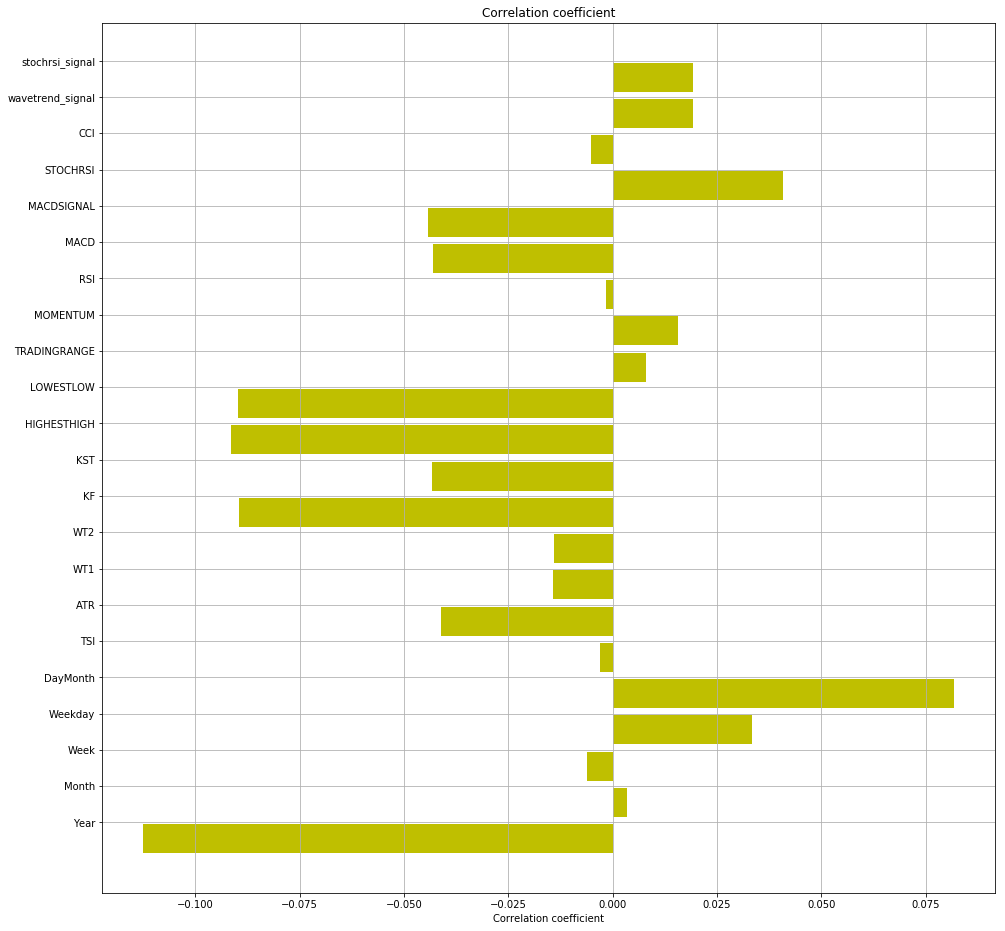

In [144]:
df = signal_overall
# Now let us look at the correlation coefficient of each of these variables
x_cols = [col for col in df.columns if col not in ['OPEN','HIGH','LOW','CLOSE','start_price','end_price',
                                                   'time_diff_hours','pct_change','weighted_target','signal','weight',]]

target_col = 'signal'
labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(df[col].values, df[target_col].values)[0,1])
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(16,16))
plt.grid(True)
rects = ax.barh(ind, np.array(values), color='y')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient")
#autolabel(rects)
plt.show()
